# Vectorized CLQ operation
The idea here is to utilize squidpy's fast neighborhood calculation, and then simply permute neighbor cluster assignments on the graph itself.
Therefore we only calculate the neighbors once, and use logical indexing to find the neighborhood composition.
The second optimization vectorizes the neighbor cluster permutations (so instead of a 1 x N_cells vector of neighbor cluster identities, it is a N_perms x N_cells matrix).
We are then able to utilize numpy's extremely fast unique counts code (C-based) to calculate neighborhood content. This calculation is parallelized across each cell. There is also potential further acceleration using GPU-based implementations (CuBLAS, CuPy, etc)

In [6]:
import numpy as np
import pandas as pd
import squidpy as sq
from multiprocessing import Pool
import glob

In [60]:
#Utilize complex numbers to vectorize permutation counts
def unique_perms(a):
    weight = 1j*np.arange(0,a.shape[0])
    b = a + weight[:, np.newaxis]
    u, cts = np.unique(b, return_counts=True)
    return u,cts

#Mapping functions for parallelization
def process_neighborhood(n):
    global t_perms,t_clust,tcell_perms
    ncv = np.zeros((t_perms+1,t_clust),dtype=np.float32)
    
    if len(n) == 0:
        return ncv
    
    j,cts = unique_perms(tcell_perms[:,n])
    ncv[np.imag(j).astype(np.int32),np.real(j).astype(np.int32)] = cts

    return ncv

def pool_ncvs(argperm,argclust,argcperms):
    global t_perms,t_clust,tcell_perms
    t_perms,t_clust,tcell_perms = argperm,argclust,argcperms

#Optimized CLQ using vectorized operations
def CLQ_vec(adata,clust_col='leiden',clust_uniq=None,radius=50,n_perms=1000):
    #Calculate spatial neighbors once.
    sq.gr.spatial_neighbors(adata,coord_type='generic',radius=radius)
    neigh_idx = adata.obsp['spatial_connectivities'].tolil()
    neighborhoods = [x + [i] for i,x in enumerate(neigh_idx.rows)] #Append self to match previous implementation? (x + [i])
    n_cells = len(neighborhoods)

    #Global frequencies.
    global_cluster_freq = adata.obs[clust_col].value_counts(normalize=True)
    if clust_uniq is None:
        clust_uniq = global_cluster_freq.index

    #Cluster identities for each cell
    cell_ids = adata.obs.loc[:,clust_col]

    #Map clusters to integers for fast vectorization in numpy
    label_dict = {x:i for i,x in enumerate(clust_uniq)}
    n_clust = len(label_dict)

    #Permute cluster identities across cells
    cell_id_perms = [[label_dict[x] for x in cell_ids]] #0th permutation is the observed NCV
    cell_id_perms.extend([[label_dict[x] for x in np.random.permutation(cell_ids)] for i in range(n_perms)])
    cell_id_perms = np.array(cell_id_perms)

    #Calculate neighborhood content vectors (NCVs). 
    p = Pool(initializer=pool_ncvs, initargs=[n_perms, n_clust, cell_id_perms])
    temp = p.map(process_neighborhood, [n for n in neighborhoods])
    p.close()
    p.join()

    ncv = np.array(temp).transpose((1,0,2))
    ncv = ncv/ncv.sum(axis=2)[:,:,np.newaxis]

    #Old single-threaded version.
    '''
    ncv = np.zeros((n_perms+1,n_cells,n_clust),dtype=np.float32)
    for i,cell_neighborhood in enumerate(neighborhoods):
        if len(cell_neighborhood) == 0:
            continue

        j,cts = unique_perms(cell_id_perms[:,cell_neighborhood])
        ncv[np.imag(j).astype(np.int32),i,np.real(j).astype(np.int32)] = cts
    '''
    
    #Read out local CLQ from NCV vectors
    local_clq = ncv/np.array([global_cluster_freq[x] for x in label_dict])
    
    #Average local_clq over clusters to get global CLQ
    global_clq = np.array([np.nanmean(local_clq[cell_id_perms == label_dict[x],:].reshape(n_perms+1,-1,n_clust),1) for x in label_dict])

    #Read out the observed local and global CLQs
    idx = [x for x in label_dict]
    lclq = pd.DataFrame(local_clq[0,:,:],columns=idx)
    gclq = pd.DataFrame(global_clq[:,0,:],index=idx,columns=idx)

    #Permutation test
    clq_perm = (global_clq[:,1:,:] < global_clq[:,0,:].reshape(n_clust,-1,n_clust)).sum(1)/n_perms
    clq_perm = pd.DataFrame(clq_perm,index=idx,columns=idx)
    return lclq,gclq,clq_perm,ncv

# Original CLQ implementation for comparison

In [48]:
import os
import glob
import numpy as np
import pandas as pd

import anndata as ad
from anndata import AnnData
import scanpy as sc

from sklearn.neighbors import KDTree
from multiprocessing import Pool

In [49]:
def initializer_pool(argTree, argobs_df,argcluster_uniq):
    global tree
    global obs_df
    global cluster_uniq
    
    tree = argTree
    obs_df = argobs_df
    cluster_uniq = argcluster_uniq
    
def neighborhood_analysis(point):
    global tree
    global obs_df
    global cluster_uniq
    
    pt = np.reshape(point, (-1, 2))
    ndx = tree.query_radius(pt, r=50)

    neighborhood = [obs_df[i] for i in ndx[0].tolist()]
    cluster_count=[]
    for cluster in cluster_uniq:
        cluster_count.append(neighborhood.count(cluster))

    return cluster_count

def adjaceny_count(points,tree,obs_df,cluster_uniq):
    p = Pool(initializer=initializer_pool, initargs=[tree, obs_df,cluster_uniq])
    temp = p.map(neighborhood_analysis, [i for i in points], chunksize=10)

    p.close()
    p.join()

    count_df = pd.DataFrame(temp,columns = ['nhood_count '+x for x in cluster_uniq])
    
    return count_df

def calc_clqs(count_df,global_freq_df,cluster_uniq,obs_df,cluster_obs):
    freq_df= count_df.div(count_df.sum(axis=1), axis=0)
    local_clq=freq_df.div(global_freq_df.iloc[0], axis='columns')  # Divide local (neighborhood) frequency by global frequency to get the local CLQ
    
    local_clq[cluster_obs]=obs_df

    # Get mean of each cluster's local CLQ to generate the global CLQ
    global_clq = pd.DataFrame(columns = cluster_uniq)

    for cl_unq in cluster_uniq:

        temp=local_clq[local_clq[cluster_obs]==cl_unq]

        if len(temp)>0:
            temp=temp.mean()
            global_clq.loc[len(global_clq)] = temp.values[:-1].tolist()
        else:
            global_clq.loc[len(global_clq)] = np.nan
    
    return local_clq,global_clq

def CLQ(adata,cluster_uniq,cluster_obs='cluster_id', radius=50, num_permute=1000):
    
    """Calculates local and global CLQ for a given image stored in anndata object
    
    Parameters
    ----------
    adata : Anndata object. Anndata object must contain 2D numpy adata['spatial'].obsm which contains [x,y] coordinate. 
            Also, an obs column with cluster ID/name
    cluster_uniq: A list of all unique cluster names (get from study level data). We do this as a parameter since some images may not contain a given cluster. 
    cluster_obs: string name of cluster column
    radius: neighborhood size in pixels
    num_permute: number of permutations for CLQ null hypothesis test
 
    Returns
    -------
    adata : Anndata object with appended neighborhood counts and local CLQ values as per cluster ID/name obs. And global CLQ and permutation score matrices in uns. 
    
    """
    obs_df=adata.obs[cluster_obs]
    obs_df=[str(x) for x in obs_df]
    
    global_cluster_count=[]       # Get global (per image) counts of each cluster
    for cluster in cluster_uniq:
        global_cluster_count.append(obs_df.count(cluster))

    total_count=sum(global_cluster_count)   # Get global frequency for each cluster
    global_cluster_freq=[x/total_count for x in global_cluster_count]
    global_freq_df = pd.DataFrame([global_cluster_freq],columns = ['nhood_count '+x for x in cluster_uniq])

    points=adata.obsm['spatial'].tolist()   # Create KDTree
    tree=KDTree(points)
    
    count_df=adjaceny_count(points,tree,obs_df,cluster_uniq)
    
    local_clq,global_clq=calc_clqs(count_df,global_freq_df,cluster_uniq,obs_df,cluster_obs)
    #global_clq['']
    
    #permute
    permute_test=global_clq*0

    for z in range(num_permute):
        obs_df_permute=adata.obs[cluster_obs].sample(frac=1).reset_index(drop=True) # randomly permute dataframe
        obs_df_permute=[str(x) for x in obs_df_permute]
        
        count_df_permute=adjaceny_count(points,tree,obs_df_permute,cluster_uniq)
        
        local_clq_permute,global_clq_permute=calc_clqs(count_df_permute,global_freq_df,cluster_uniq,obs_df_permute,cluster_obs)
        
        global_clq_permute = pd.DataFrame(columns = cluster_uniq)
        for cl_unq in cluster_uniq:

            temp=local_clq_permute[local_clq_permute[cluster_obs]==cl_unq]

            if len(temp)>0:
                temp=temp.mean()
                global_clq_permute.loc[len(global_clq_permute)] = temp.values[:-1].tolist()
            else:
                global_clq_permute.loc[len(global_clq_permute)] = np.nan

            

        permute_test=permute_test+(global_clq>global_clq_permute)*1

    permute_test=(permute_test/num_permute)
    
    local_clq=local_clq.iloc[:,:-1]
    new_names=['localCLQ to '+x.split('nhood_count ')[1] for x in local_clq.columns.tolist()]
    local_clq.columns=new_names

    global_clq.index = global_clq.columns.tolist()
    permute_test.index = permute_test.columns.tolist()
    
    return local_clq, global_clq, permute_test

# Example usage on same data.

In [44]:
import os
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
os.chdir('/gne/data/pathology/t3imagedata/Projects/SPEX/IMC-Control_Tonsil/')
annfiles = glob.glob('*.h5ad', recursive = False)
file=annfiles[0]
adata = ad.read_h5ad(file)

obs_df=adata.obs['cluster_id']   
cluster_uniq=list(set(obs_df))

/gstore/home/fooc5/pyenvs/squidpy_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [62]:
%%time
lclq_vec,gclq_vec,ptest_vec = CLQ_vec(adata,clust_col='cluster_id',clust_uniq=cluster_uniq, radius=50, n_perms=10) # execute on single image anndata object

CPU times: user 3.71 s, sys: 1.67 s, total: 5.38 s
Wall time: 5.55 s


In [63]:
obs_df=adata.obs['cluster_id']    # Get unique cluster names (as string) in the dataset
obs_df=[str(x) for x in obs_df]  
cluster_uniq=list(set(obs_df))

In [64]:
%%time
lclq,gclq,ptest = CLQ(adata, cluster_uniq, cluster_obs='cluster_id',radius=50,num_permute=10)

CPU times: user 10.1 s, sys: 13.3 s, total: 23.4 s
Wall time: 27.9 s


# Scaling with large n_permutations

The vectorized formulation is designed to scale with large permutation number and large cell counts. Let's look at scaling across permutations

In [84]:
#Try again with more permutations
import time
nperms = [10,100,1000]

In [85]:
os.chdir('/gne/data/pathology/t3imagedata/Projects/SPEX/IMC-Control_Tonsil/')
annfiles = glob.glob('*.h5ad', recursive = False)
file=annfiles[0]
adata = ad.read_h5ad(file)

obs_df=adata.obs['cluster_id']   
cluster_uniq=list(set(obs_df))

/gstore/home/fooc5/pyenvs/squidpy_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [86]:
vec_time = []
for p in nperms:
    st = time.time()
    _ = CLQ_vec(adata,clust_col='cluster_id',clust_uniq=cluster_uniq, radius=50, n_perms=p) # execute on single image anndata object
    vec_time.append(time.time()-st)

In [88]:
obs_df=adata.obs['cluster_id']    # Get unique cluster names (as string) in the dataset
obs_df=[str(x) for x in obs_df]  
cluster_uniq=list(set(obs_df))

In [89]:
orig_time = []
for p in nperms:
    st = time.time()
    _ = CLQ(adata, cluster_uniq, cluster_obs='cluster_id',radius=50,num_permute=p)
    orig_time.append(time.time()-st)

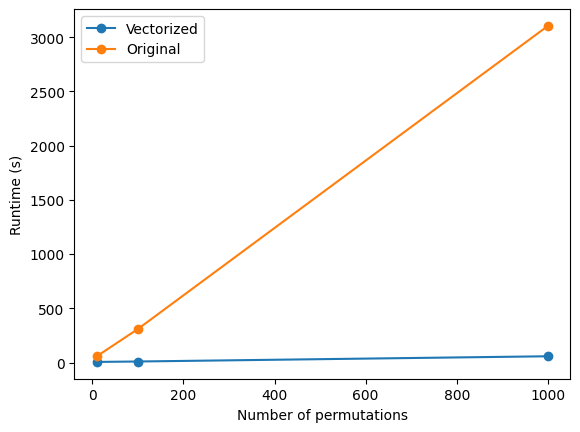

In [91]:
plt.plot(nperms,vec_time,'-o',label='Vectorized')
plt.plot(nperms,orig_time,'-o',label='Original')

plt.legend()
plt.xlabel('Number of permutations')
plt.ylabel('Runtime (s)')

plt.show()

# Compare results

In [92]:
gclq = gclq.loc[[str(x) for x in gclq_vec.index],[str(x) for x in gclq_vec.columns]]
gclq.head()

,512,133,654,275,796,417,939,559,180,702,322,844,465,85,607,228,749,370,891
512,6.586941,1.612697,1.481490,0.073114,0.049693,1.310956,0.046330,3.256153,0.125935,1.632902,0.032017,0.016403,3.702070,0.231363,0.505243,0.032987,0.627999,2.474129,0.273258
133,1.579704,3.816733,1.628253,0.103387,0.207121,2.256569,0.159430,2.227756,0.175687,2.337760,0.078775,0.027474,0.770261,0.447281,0.504238,0.059301,1.396815,2.040046,0.278912
654,1.432264,1.625603,4.843501,0.070387,0.400432,2.395607,0.499542,0.889554,0.449279,1.489511,0.064869,0.013406,1.051237,0.153266,0.550099,0.051021,0.959494,2.101446,0.981637
275,0.073831,0.104462,0.071666,3.855682,0.540075,0.102297,0.507831,0.073533,0.591743,0.143165,1.341221,2.074442,0.383473,2.297674,0.951704,3.450778,0.596679,0.075991,0.340947
796,0.046658,0.202081,0.396492,0.533423,3.424364,0.287179,1.991449,0.053213,2.260839,0.296075,1.488340,0.331822,0.195984,0.367440,1.316608,0.317498,1.455544,0.240563,1.637631


In [93]:
gclq_vec.head()

,512,133,654,275,796,417,939,559,180,702,322,844,465,85,607,228,749,370,891
512,6.586941,1.612697,1.481490,0.073114,0.049693,1.310956,0.046330,3.256153,0.125935,1.632902,0.032017,0.016403,3.702070,0.231363,0.505243,0.032987,0.627999,2.474129,0.273258
133,1.579704,3.816733,1.628253,0.103387,0.207121,2.256569,0.159430,2.227756,0.175687,2.337760,0.078775,0.027474,0.770261,0.447281,0.504238,0.059301,1.396815,2.040046,0.278912
654,1.432264,1.625603,4.843501,0.070387,0.400432,2.395607,0.499542,0.889554,0.449279,1.489511,0.064869,0.013406,1.051237,0.153266,0.550099,0.051021,0.959494,2.101446,0.981637
275,0.073831,0.104462,0.071666,3.855682,0.540075,0.102297,0.507831,0.073533,0.591743,0.143165,1.341221,2.074442,0.383473,2.297674,0.951704,3.450778,0.596679,0.075991,0.340947
796,0.046658,0.202081,0.396492,0.533423,3.424364,0.287179,1.991449,0.053213,2.260839,0.296075,1.488340,0.331822,0.195984,0.367440,1.316608,0.317498,1.455544,0.240563,1.637631


In [94]:
#Is each element close in the global clq?
np.allclose(gclq_vec,gclq)

True

In [95]:
lclq = lclq.loc[:,['localCLQ to '+str(x) for x in lclq_vec.columns]]
lclq.head()

,localCLQ to 512,localCLQ to 133,localCLQ to 654,localCLQ to 275,localCLQ to 796,localCLQ to 417,localCLQ to 939,localCLQ to 559,localCLQ to 180,localCLQ to 702,localCLQ to 322,localCLQ to 844,localCLQ to 465,localCLQ to 85,localCLQ to 607,localCLQ to 228,localCLQ to 749,localCLQ to 370,localCLQ to 891
0,16.357984,0.0,1.196253,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.400178,0.000000
1,14.973847,0.0,1.016815,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.585852,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.720202,0.000000
2,11.518344,0.0,3.910827,0.000000,0.000000,1.103344,0.000000,0.0,0.0,0.450656,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.615578,0.000000
3,0.000000,0.0,0.000000,3.107866,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.859888,0.0,4.120888,0.000000,4.910579,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,2.496825,0.000000,4.733142,0.0,0.0,0.000000,3.150306,0.000000,0.0,2.666457,1.490213,1.059145,0.0,0.000000,1.846226


In [96]:
lclq_vec.head()

,512,133,654,275,796,417,939,559,180,702,322,844,465,85,607,228,749,370,891
0,16.357985,0.0,1.196253,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.400178,0.000000
1,14.973847,0.0,1.016815,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.585852,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.720202,0.000000
2,11.518345,0.0,3.910827,0.000000,0.000000,1.103345,0.000000,0.0,0.0,0.450656,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.615578,0.000000
3,0.000000,0.0,0.000000,3.107866,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.859888,0.0,4.120888,0.000000,4.910580,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,2.496825,0.000000,4.733142,0.0,0.0,0.000000,3.150306,0.000000,0.0,2.666457,1.490213,1.059145,0.0,0.000000,1.846226


In [97]:
#How about local clq?
np.allclose(lclq,lclq_vec)

True

In [98]:
ptest = ptest.loc[[str(x) for x in ptest_vec.index],[str(x) for x in ptest_vec.columns]]

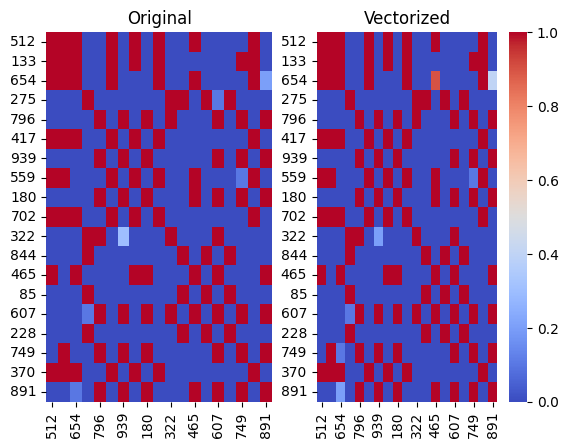

In [99]:
#How about heatmaps?
f,a = plt.subplots(1,2)

sns.heatmap(
    data=ptest,
    cmap='coolwarm',
    vmax=1,
    vmin=0,
    ax=a[0],
    cbar=False
)

sns.heatmap(
    data=ptest_vec,
    cmap='coolwarm',
    vmax=1,
    vmin=0,
    ax=a[1],
)

a[0].set_title('Original')
a[1].set_title('Vectorized')
plt.show()